<a href="https://colab.research.google.com/github/ibonetc/IA_Pregrado_-2025/blob/main/IA_EIA_ParaTP_LatLong_InformacionMapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install requests --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


# Localización en mapas

Captura de información para poder hacer métodos de rutas

Se debe instalar el paquete osmnx, que permite obtener mapas en un grafo con información de latitud y longitud de diferentes puntos, con sus distancias

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 1.8 MB/s eta 0:00:00


In [2]:
!pip install plotly_express

**Nota** : Después de instalar la biblioteca osmnx debe reiniciar el entorno de ejecuación y entonces ejecutar el siguiente código

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox
#ox.config(use_cache=True, log_console=True)

## Mapa de Envigado

La función **graph_from_place** recibe un texto con la dirección del lugar que se desea buscar, y tiene un parámetro *network_type* para ver cómo se desea obtener el mapa, en nuestro caso que queremos hacer ruts para trayecto en carro escogeremos: 'drive'

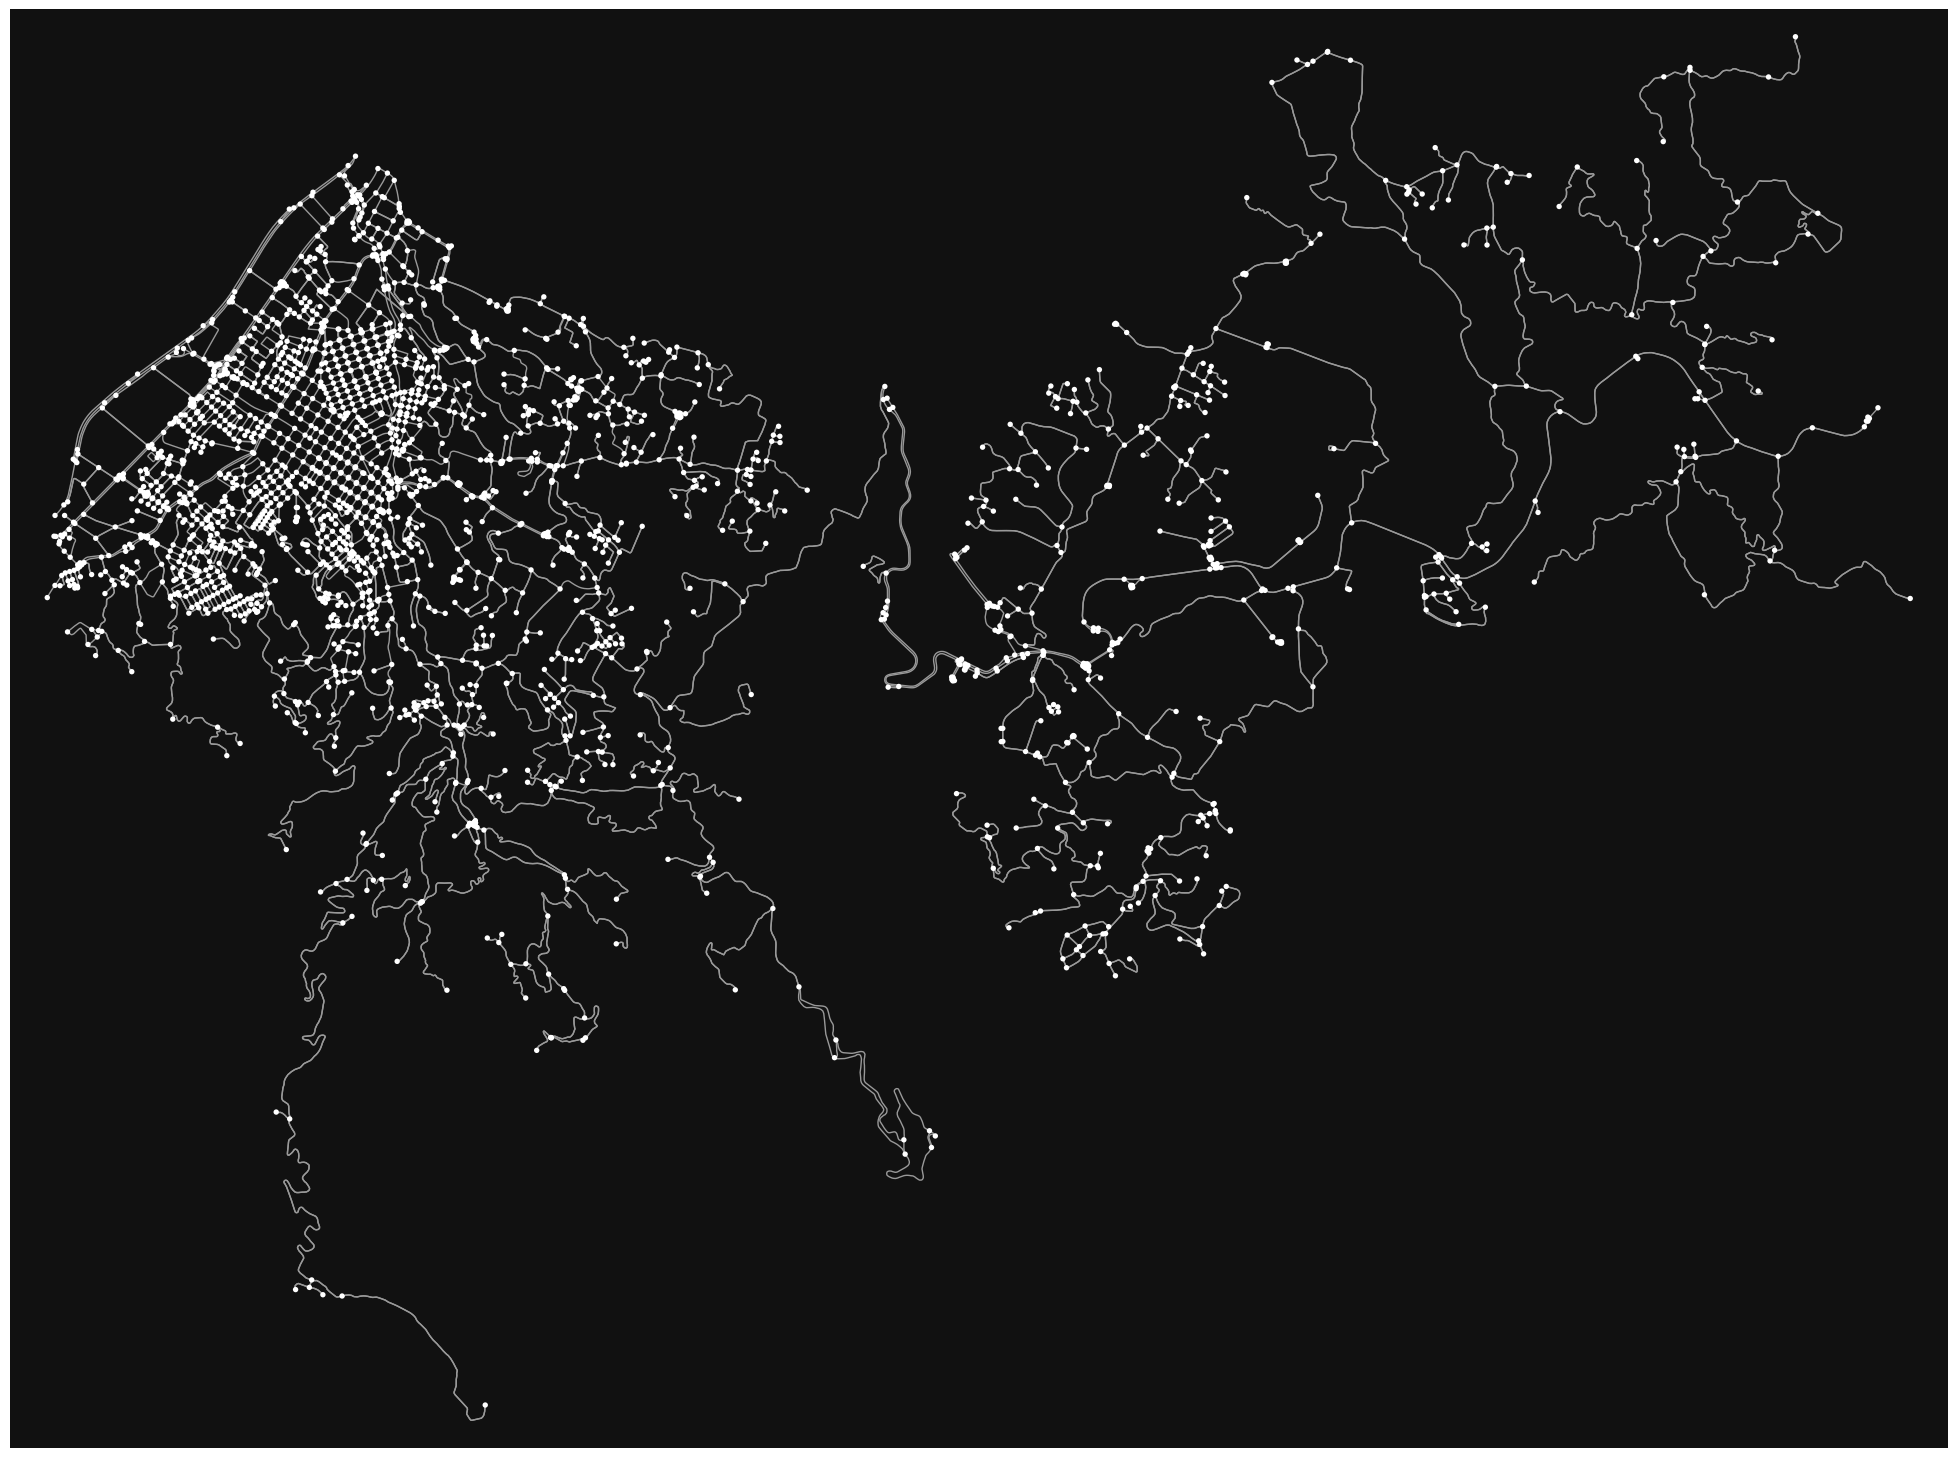

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive')
ox.plot_graph(G,figsize=(25,25))

La función por defecto tiene un parámetro *simplify* puesto en True, por lo que trae un grafo simplificado, con pocos puntos. Como queremos tratar de mostrar el trayecto completo de la ruta vamos a traer más información del mapa y pondremos el parámetro en False.

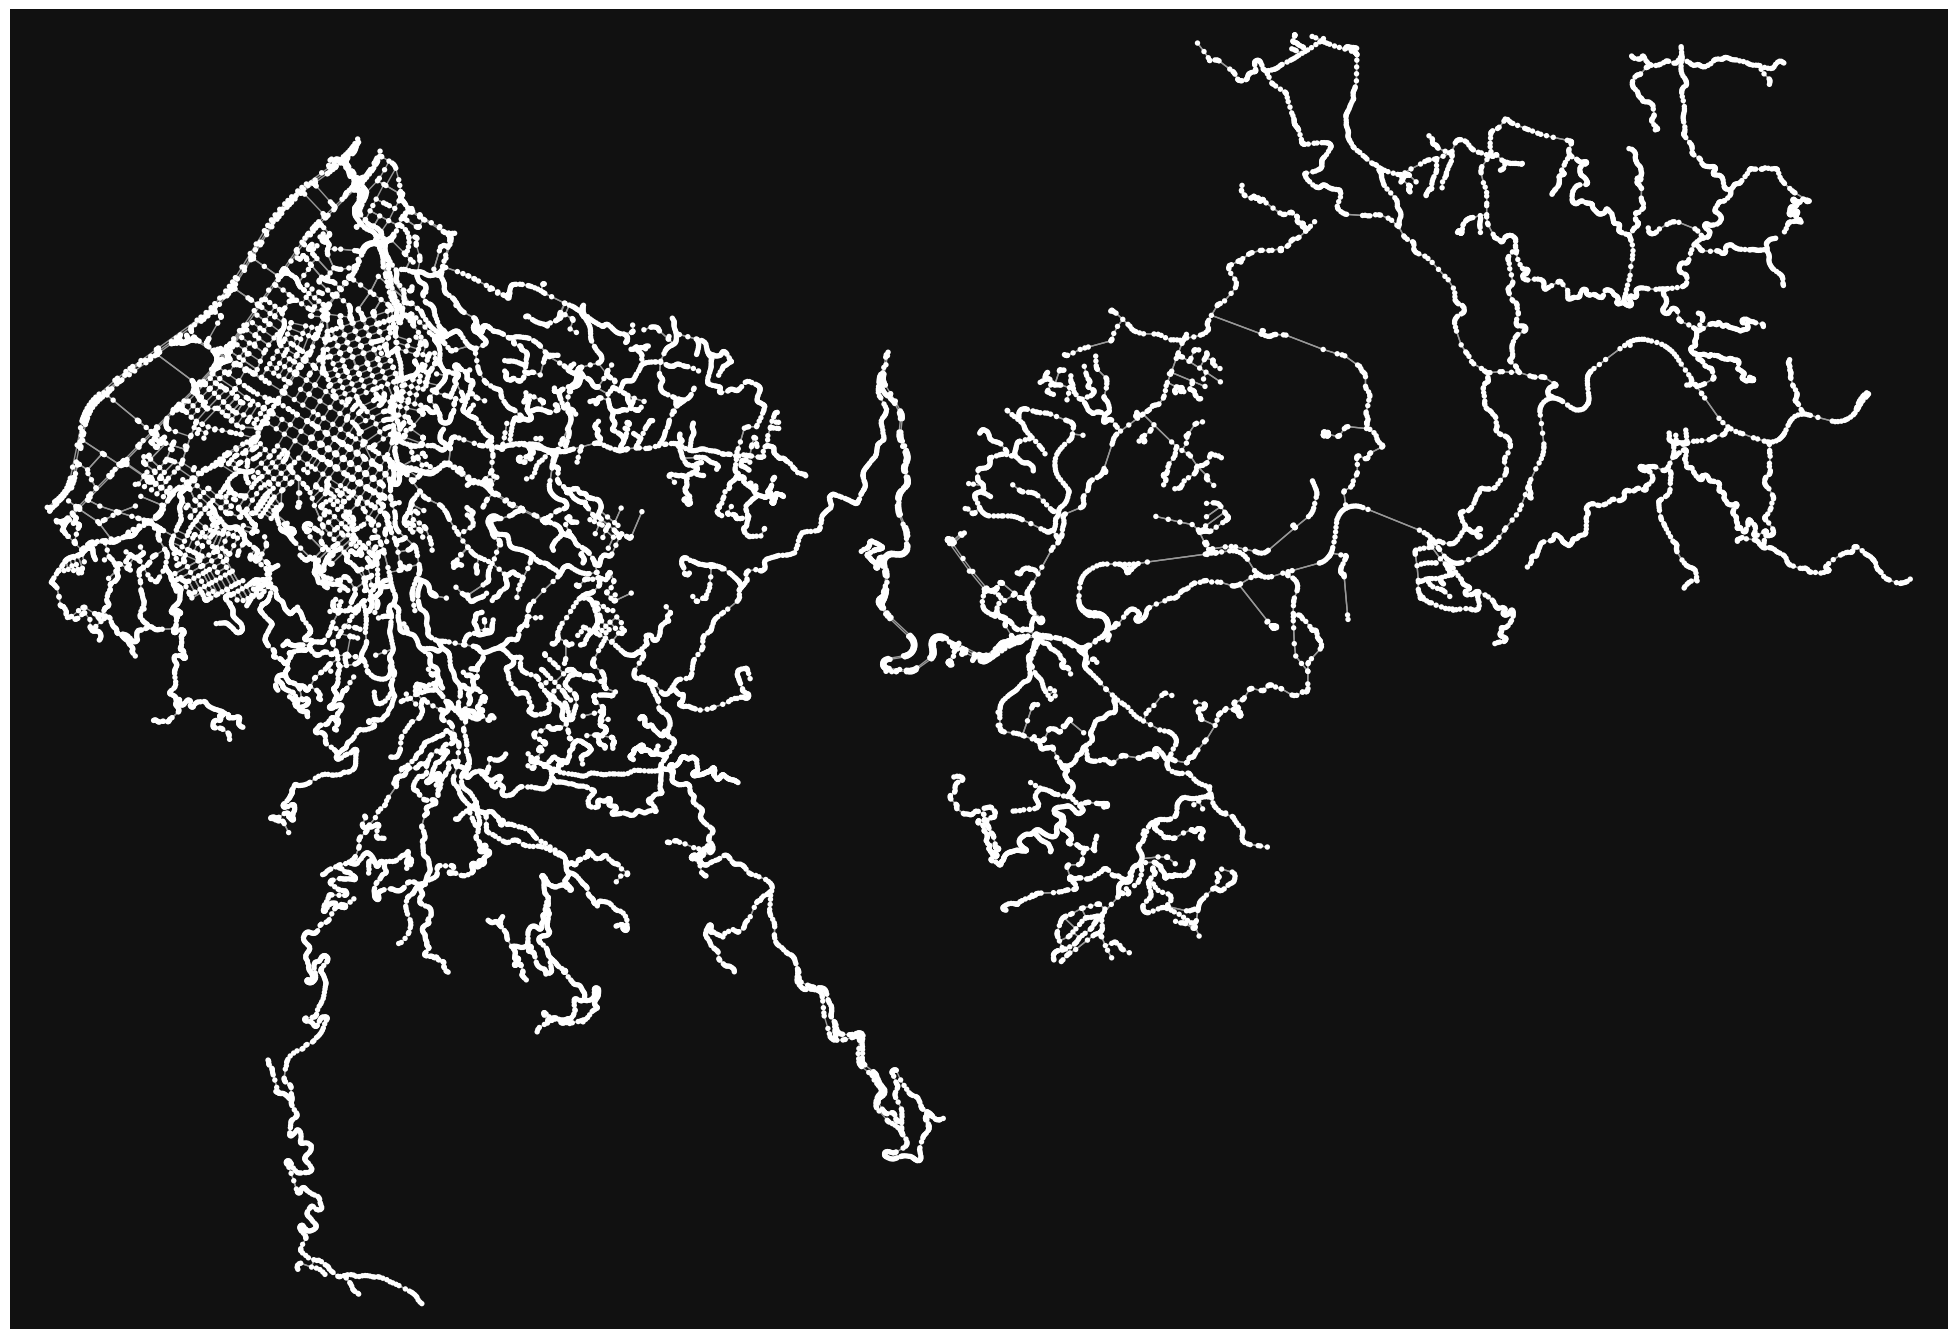

(<Figure size 2500x2500 with 1 Axes>, <Axes: >)

In [3]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive',simplify=False)
ox.plot_graph(G,figsize=(25,25))

La función *graph_to_gdfs(G)* nos devuelve dos dataframe uno con los nodos y otro con las aristas del grafo.

In [4]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [5]:
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
309313450,6.158425,-75.519823,2,NaN,POINT (-75.51982 6.15843)
309313451,6.158399,-75.520285,2,NaN,POINT (-75.52028 6.1584)
309313454,6.159630,-75.521495,2,NaN,POINT (-75.5215 6.15963)
309313455,6.160208,-75.522473,2,NaN,POINT (-75.52247 6.16021)
309313457,6.159973,-75.524408,3,NaN,POINT (-75.52441 6.15997)


In [6]:
gdf_edges.head()

osmid    highway lanes maxspeed  \
u         v          key                                         
309313450 414940715  0    1019189334  secondary     2       50   
          440765240  0    1019189334  secondary     2       50   
309313451 414940727  0    1019189334  secondary     2       50   
          414940715  0    1019189334  secondary     2       50   
309313454 4124260034 0    1019190824  secondary     2       60   

                                         name  oneway  reversed     length  \
u         v          key                                                     
309313450 414940715  0    Variante Las Palmas   False     False  24.138083   
          440765240  0    Variante Las Palmas   False      True  91.294214   
309313451 414940727  0    Variante Las Palmas   False     False  26.537531   
          414940715  0    Variante Las Palmas   False      True  27.314193   
309313454 4124260034 0    Variante Las Palmas   False     False  25.381809   

                          ref width junction bridge access  \
u         v          key                                     
309313450 414940715  0    NaN   NaN      NaN    NaN    NaN   
          440765240  0    NaN   NaN      NaN    NaN    NaN   
309313451 414940727  0    NaN   NaN      NaN    NaN    NaN   
          414940715  0    NaN   NaN      NaN    NaN    NaN   
309313454 4124260034 0    NaN   NaN      NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0     LINESTRING (-75.52028 6.1584, -75.52051 6.15847)  
          414940715  0     LINESTRING (-75.52028 6.1584, -75.52004 6.15839)  
309313454 4124260034 0     LINESTRING (-75.5215 6.15963, -75.52164 6.15981)

Si observamos una parte del dataframe de las aristas, podemos ver que tenemos toda la información donde *u* es el nodo de partida, *v* el nodo de destino en cada uno de las conecciones de los puntos, tenemos el nombre del lugar o calle (name), el tipo de carretera (highway), la máxima velocidad en ese lugar (maxspeed), pero esta variable tiene varios nulos, para poder calcular tiempo en recurrido necesitamos llenar estos campos vacíos.

Podemos crear una variable speed_kph que se completa con los valores maxspeed y rellena los vacíos, por defecto, la función add_edge_speeds(G) rellena los vacíos con el promedio de ese tipo de carretera, en el mapa, pero podemos también pasarle unos valores fijos, como se hizo anteriormente.

Adicionar una columna con velocidad (**speed_kph**), a partir de la maxspeed que hay

Adicionar otra columna con el tiempo de viaje (**travel_time**)

In [7]:
#G = ox.add_edge_speeds(G)
# Para que en vez del promedio del tipo de vía, ponga uno específico como esté null
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [8]:
gdf_edges[150:200]

osmid       highway lanes maxspeed  \
u         v           key                                            
330634181 8895905673  0    1018644386   residential     3      NaN   
330634666 1378816147  0     297281673   residential   NaN      NaN   
          330634181   0     577258425     secondary     3      NaN   
330634667 8895905676  0     123728026   residential     2      NaN   
          330634666   0     577258425     secondary     3      NaN   
          3924033402  0    1018623735   residential     2      NaN   
330634668 330634667   0     577258425     secondary     3      NaN   
          1378816149  0    1018848145   residential     1       30   
330634669 5534334357  0     351458389     secondary     3      NaN   
          10174239725 0    1018623736   residential     2      NaN   
330634981 10699845192 0     351458388     secondary     2      NaN   
330634987 10774142105 0     389248617      tertiary     1      NaN   
          5529679663  0     576533571     secondary     2       30   
330634988 10174239750 0     577255132     secondary     3       30   
          10174239752 0    1018848587   residential     2      NaN   
330634990 3924033388  0     577255133     secondary     2       30   
          9397383703  0    1018851100   residential     2      NaN   
330634991 9397383706  0     576533589     secondary     1       30   
          10724477198 0    1018851099   residential     1      NaN   
330634992 10174239735 0     576533588     secondary     1       30   
          10174239737 0    1018848140   residential     2      NaN   
330634993 10174239723 0     576533588     secondary     1       30   
          5529679696  0    1018848147   residential     2      NaN   
330634994 8895905677  0    1018848145   residential     1       30   
          10174239712 0    1018848148     secondary     1       30   
330634995 10724514155 0     123728026   residential     2      NaN   
          10724477202 0     906423565     secondary     2       40   
330634997 8895905674  0     297281673   residential   NaN      NaN   
          10724514108 0     576533591     secondary     3       40   
330634999 8895905678  0     154884791   residential     2      NaN   
          10724514128 0     577255130     secondary     3       30   
330635000 10724514134 0     577255130     secondary     3       30   
          10724514160 0    1019184059   residential     1      NaN   
330635001 10724514140 0     576112578     secondary     3      NaN   
330636751 11986724602 0    1306708835  unclassified     1      NaN   
330636752 6927580879  0     935662832  unclassified     1      NaN   
330636754 5496798845  0     935662811     secondary     2      NaN   
330636755 11986703631 0    1292978638     secondary     2      NaN   
330636756 10699863702 0    1292978638     secondary     2      NaN   
330636757 3576471509  0    1292978638     secondary     2      NaN   
330636759 3576471503  0    1292978638     secondary     2      NaN   
330636760 3576471371  0    1292978638     secondary     2      NaN   
330636765 330636766   0    1150201140     secondary     2      NaN   
330636766 4404924426  0    1150201140     secondary     2      NaN   
330636767 10699863651 0      44923416   residential   NaN       40   
          4404924412  0    1150201140     secondary     2      NaN   
330636769 4404924283  0    1150201140     secondary     2      NaN   
330636770 9396988942  0    1150201140     secondary     2      NaN   
330636771 9396988941  0    1150201140     secondary     2      NaN   
330636772 569680296   0    1150201140     secondary     2      NaN   

                                   name  oneway  reversed     length  \
u         v           key                                              
330634181 8895905673  0      Carrera 40    True     False  80.180967   
330634666 1378816147  0      Carrera 39    True     False  99.552865   
          330634181   0    Calle 37 Sur    True     False  85.411989   
330634667 8895905676  0      Ca

In [9]:
gdf_edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
primary,24.6,49.1,1.9
primary_link,7.7,30.0,0.9
residential,18.4,34.6,1.9
secondary,20.6,47.6,1.6
secondary_link,5.2,47.7,0.4
tertiary,17.8,57.3,1.2
tertiary_link,6.6,47.7,0.5
trunk,51.5,80.0,2.3
trunk_link,19.1,47.7,1.4


Si necesitamos buscar latitudes y longitudes de lugares específicos para buscar en un mapa podemos usar el biblioteca geopy que con Nominatim que nos permite hacerlo gratis

## Ejemplo de mostrar una ruta

In [10]:
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')

Acá busco la longitud y latitud de la Sede de posgrados de la EIA y la sede de Palmas. Esto devuelve una variable que tiene la dirección completa y la longitud y latitud

In [11]:
location_start = locator.geocode('Sede Posgrados EIA, Envigado, Colombia')
location_end=locator.geocode('Universidad EIA, Envigado, Colombia')

In [12]:
print(location_start.address)
print(location_end.address)

Sede Posgrados EIA, Calle 25 Sur, La Magnolia, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, 055422, Colombia
Escuela de Ingeniería de Antioquia, km 2+200, Vía Acceso P. Palmitas, Envigado, Valle de Aburrá, Antioquia, RAP del Agua y la Montaña, Colombia


In [13]:
print((location_start.latitude, location_start.longitude))
print((location_end.latitude, location_end.longitude))

(6.1789229, -75.579478)
(6.1569601, -75.5168548)


Como un ejemplo de mostrar una ruta en el mapa vamos a usar la biblioteca nx con la función ***shortest_path*** que recibe un grafo de mapa, un punto de origen y uno de destino y según un peso, en este caso tiempo (por la columna *travel_time*), busca una ruta utilizando el algoritmo *dijkstra*.

Con la función ***plot_graph_route*** de ox se puede dibujar una ruta, se le debe pasar una lista de la ruta con los códigos de los nodos del grafo a dibujar en la ruta.

In [16]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)
start_node = ox.distance.nearest_nodes(G, start[1],start[0])
end_node = ox.distance.nearest_nodes(G, end[1],end[0])
route1 = nx.shortest_path(G, start_node, end_node, weight='travel_time')
print(route1)

[9397052814, 340686744, 340686745, 340686746, 4404924419, 4404924420, 340686060, 4404924418, 4404924417, 3648101524, 340686059, 4404924394, 3648101523, 3648101522, 4404924400, 4404924399, 4404924397, 4404924395, 3648102739, 3648102740, 338172930, 4404924390, 9395190159, 338172929, 3648101520, 9694338780, 9395190160, 4404924284, 338172928, 9395190161, 9395190162, 338172927, 9395190163, 3572367329, 7115606670, 9395190164, 338172926, 9395190165, 340685471, 1841397085, 9395276470, 9395190166, 1841397172, 12050426229, 9395190167, 1841397053, 1841397105, 1841397060, 9395190168, 12050427870, 12050427871, 12050427872, 12050427873, 12050427874, 12050427875, 12050427876, 12050427895, 12050427877, 12050427898, 12050427878, 12050427879, 12050427880, 12050427881, 12050427882, 12050427883, 12050427884, 12050427885, 12050427886, 12050427888, 12050427887, 9395190170, 1841397062, 3572367314, 1841397088, 1841397063, 1841397076, 3572367298, 3572367297, 1841397051, 9395160235, 1841397147, 3924033541, 1841

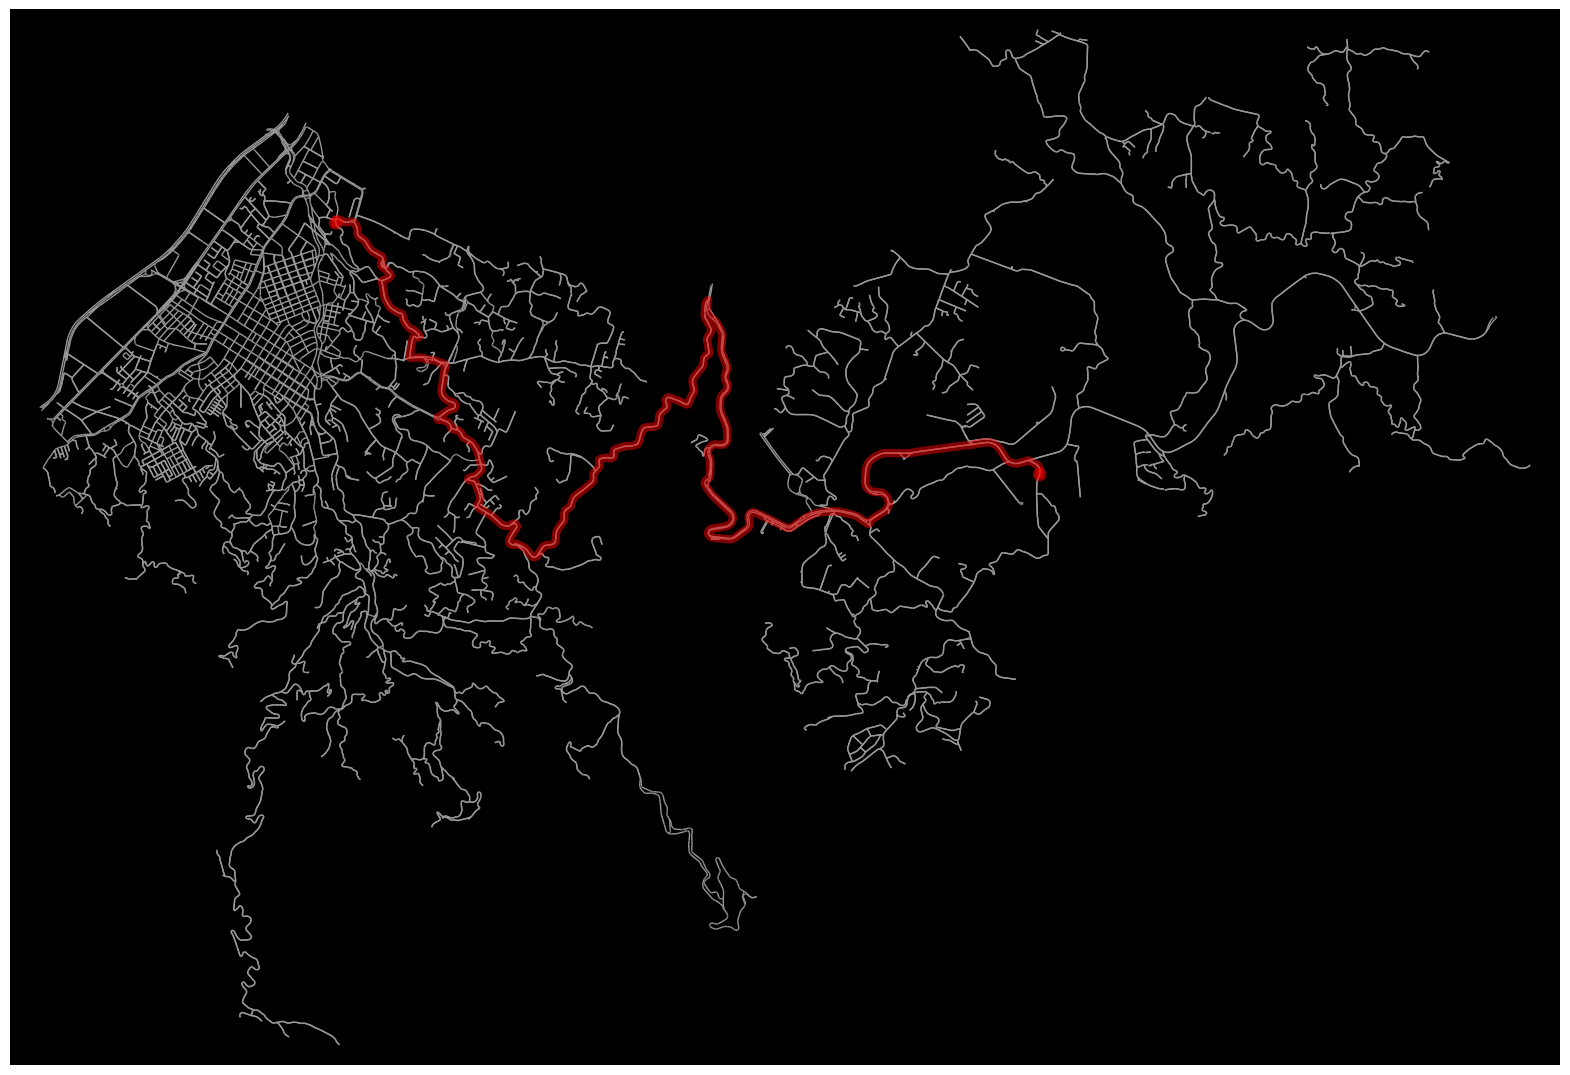

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [17]:
ox.plot_graph_route(G, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

Podemos hacer el mismo ejemplo buscando otra ruta pero ahora por distancia (en este caso usaríamos como peso la columna *length*)

In [18]:
route2 = nx.shortest_path(G, start_node, end_node, weight='length')

Comparar las dos rutas

In [23]:
route1_length = int(sum(G.edges[u, v, 0]['length'] for u, v in zip(route1[:-1], route1[1:])))
route2_length = int(sum(G.edges[u, v, 0]['length'] for u, v in zip(route2[:-1], route2[1:])))
route1_time = int(sum(G.edges[u, v, 0]['travel_time'] for u, v in zip(route1[:-1], route1[1:])))
route2_time = int(sum(G.edges[u, v, 0]['travel_time'] for u, v in zip(route2[:-1], route2[1:])))

print('Ruta 1 tiene', route1_length, 'metros y toma', route1_time, 'segundos.')
print('Ruta 2 tiene', route2_length, 'metros y toma', route2_time, 'segundos.')

Ruta 1 tiene 15999 metros y toma 1332 segundos.
Ruta 2 tiene 15295 metros y toma 1385 segundos.


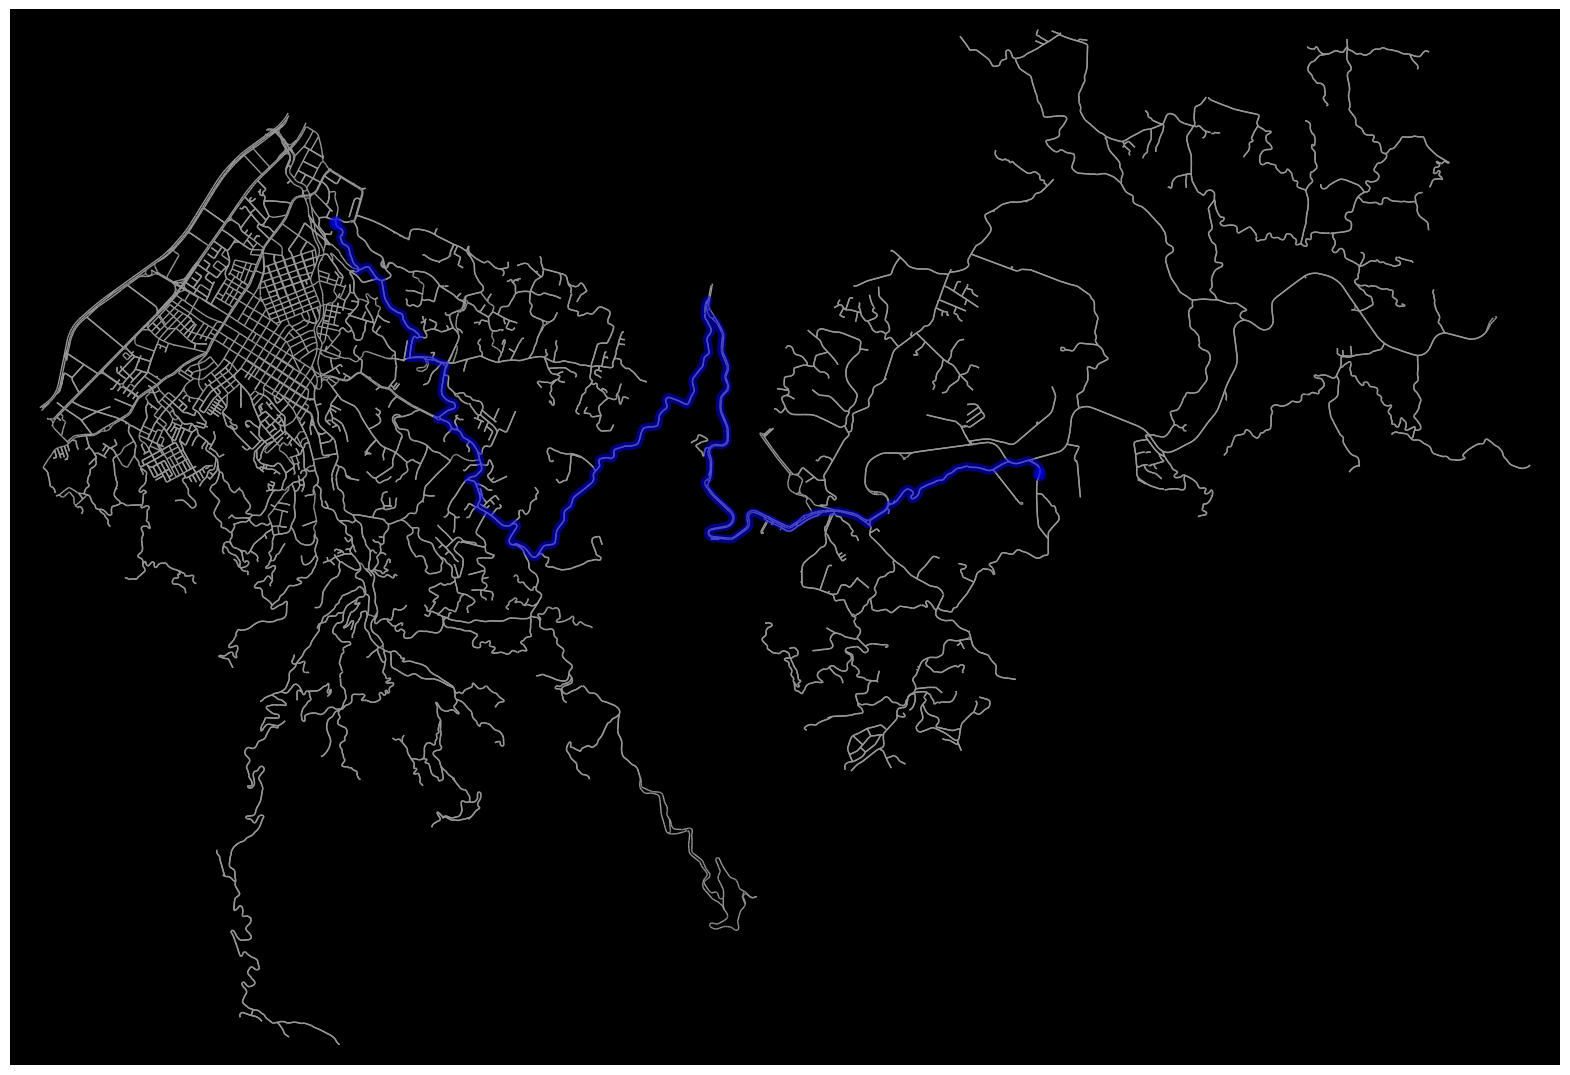

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

In [24]:
ox.plot_graph_route(G, route2, route_color='b',route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

## Dataframe geográfico con información del mapa

Podemos crear nuestro propio dataframe con los datos que tenemos en el grafo

In [25]:
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []

for u, v in zip(route1[:-1], route1[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [26]:
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)),
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"])
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,9397052814,340686744,-75.579015,6.179106,-75.579029,6.179189,9,1
1,340686744,340686745,-75.579029,6.179189,-75.579025,6.179278,10,1
2,340686745,340686746,-75.579025,6.179278,-75.578987,6.179407,15,2
3,340686746,4404924419,-75.578987,6.179407,-75.578899,6.179419,10,1
4,4404924419,4404924420,-75.578899,6.179419,-75.578824,6.179422,8,1


In [27]:
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,9397052814,340686744,-75.579015,6.179106,-75.579029,6.179189,9,1
1,1,340686744,340686745,-75.579029,6.179189,-75.579025,6.179278,10,1
2,2,340686745,340686746,-75.579025,6.179278,-75.578987,6.179407,15,2
3,3,340686746,4404924419,-75.578987,6.179407,-75.578899,6.179419,10,1
4,4,4404924419,4404924420,-75.578899,6.179419,-75.578824,6.179422,8,1


Crear un dataframe geográfico a partir de este para poder tneer las longitudes y latitudes comp puntos geométricos

In [28]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

In [29]:
df.tail()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
903,903,4124260023,440765236,-75.518227,6.158228,-75.518110,6.158092,20,2
904,904,440765236,440765235,-75.518110,6.158092,-75.518046,6.157947,18,2
905,905,440765235,4124260016,-75.518046,6.157947,-75.518011,6.157794,17,2
906,906,4124260016,440765234,-75.518011,6.157794,-75.518019,6.157611,20,2
907,907,440765234,440765233,-75.518019,6.157611,-75.518052,6.157457,18,2


In [30]:
start = df[df["node_start"] == start_node]
end = df[df["node_end"] == end_node]

In [31]:
start

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,9397052814,340686744,-75.579015,6.179106,-75.579029,6.179189,9,1


In [32]:
end

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
907,907,440765234,440765233,-75.518019,6.157611,-75.518052,6.157457,18,2


## Diferentes formas de visualización en otros mapas

In [64]:
scatter_fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, mapbox_style='carto-positron')
scatter_fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from", mapbox_style='carto-positron').data[0])
display(scatter_fig)

In [67]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, mapbox_style='open-street-map')
fig.add_trace(px.scatter_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig

Mapbox requiere access token para algunas visualizaciones como:

'basic', 'streets', 'outdoors', 'light', 'dark', 'satellite', 'satellite- streets'

Sin embargo hay otros mapbox_style que no requieren access token como:

'open-street-map', 'white-bg', 'carto-positron', 'carto-darkmatter', 'stamen- terrain', 'stamen-toner', 'stamen-watercolor'

In [45]:
fig = px.scatter_mapbox(df, lon= "X_from", lat="Y_from", zoom=12, width=1000, height=600, animation_frame="index",mapbox_style='open-street-map')
fig.data[0].marker = dict(size = 12, color="black")
fig.add_trace(px.scatter_mapbox(start, lon= "X_from", lat="Y_from").data[0])
fig.data[1].marker = dict(size = 15, color="red")
fig.add_trace(px.scatter_mapbox(end, lon= "X_from", lat="Y_from").data[0])
fig.data[2].marker = dict(size = 15, color="green")
fig.add_trace(px.line_mapbox(df, lon= "X_from", lat="Y_from").data[0])
fig